# Projections

\begin{equation*}
\newcommand{\bm}[1]{\bf #1}
\newcommand{\norm}[1]{\|#1\|}
\newcommand{\nrm}[1]{|#1|}
\newcommand{\N}{{\mathbb N}}
\newcommand{\R}{{\mathbb R}}
\newcommand{\EE}{{\mathbb E}}
\newcommand{\PP}{{\mathbb P}}
\newcommand{\bpm}{\begin{pmatrix}}
\newcommand{\epm}{\end{pmatrix}}
\newcommand{\mnmz}{\operatorname*{minimize}}
\newcommand{\mxmz}{\operatorname*{maximize}}
\newcommand{\st}{\operatorname{subject\ to}}
\newcommand{\argmin}{\operatorname*{argmin}}
\newcommand{\eps}{{\varepsilon}}
\newcommand{\Fcal}{{\mathcal F}}
\newcommand{\Pcal}{{\mathcal P}}
\newcommand{\niter}{{n_{\rm iter}}}
\newcommand{\mean}{{\operatorname{mean}}}
\end{equation*}

##  0. Utilities

In [1]:
using ProjectionsExamples
using ProjectionsExamples.Projections, ProjectionsExamples.Plots,
      ProjectionsExamples.Distributions, ProjectionsExamples.LinearAlgebra,
      ProjectionsExamples.Statistics, ProjectionsExamples.Random

In [28]:
Random.seed!(666);
atol = 1e-8;

In [29]:
function timecomparison(f::Function, n)
    out, t = @timed f(n) 
    return t
end;

function timecomparison(f::Function, ns::AbstractArray; maxreps::Integer = 4)
    
    ## precompilation
    [f(minimum(n)) for k in 1:3]
    
    ts = map(ns) do n
        t = map((rep) -> timecomparison(f, n), 1:maxreps)
        return [mean(t) std(t)]
    end
    T = reduce(vcat, ts)
    return T[:,1], T[:,2]
end;

## 1. Problem (6)

\begin{equation}\label{eq:problem1}
\begin{aligned}
\mnmz_{\bm p}\ &\bm c^\top \bm p \\
\st\ &\sum_{i=1}^np_i=1,\\
&0\le p_i,\quad\forall i=1,\dots,n,\\
&\norm{\bm p-\bm p^0}_{k}\le\eps.
\end{aligned}
\end{equation}

### 1.1.Comparison with a solver

In [30]:
# Tady okomentovat, proc volime uniformni rozdeleni a sortovane c

n   = 20;
p0  = ones(n);
p0 /= sum(p0);
c   = sort(rand(Normal(0,1), n));
ε   = 0.05;

In [5]:
p_l1_solver = Projections.minimize_linear_on_simplex_exact(p0, c, ε, 1);

p_l1   = Projections.minimize_linear_on_simplex_l1(p0, c, ε);
p_l2   = Projections.minimize_linear_on_simplex_l2(p0, c, ε);
p_lInf = Projections.minimize_linear_on_simplex_lInf(p0, c, ε);

In [6]:
# Staci jednou, netreba spoustukrat
println("Comparison of our solution with the solution given by a solver \n")
println("‖p_solver - p‖  = ", norm(p_l1_solver .- p_l1), "\n");

# Jak jsi psal Optimal solution a Our solution, tak to evokuje, ze nase reseni neni optimal.
# To, co jsem psal ja je tez spatne. Zkus neco vymyslet :)

println("Our solution: ")
println("  ⋅ c'*p = ", c'*p_l1)
println("  ⋅ ∑p = 1:       ", sum(p_l1), " = ", 1)
println("  ⋅ ‖p - p0‖ ≦ ε: ", norm(p_l1 .- p0,1), " ≦ ", ε, "\n")
println("Solver solution: ")
println("  ⋅ c'*p = ", c'*p_l1_solver)
println("  ⋅ ∑p = 1:       ", sum(p_l1_solver), " = ", 1)
println("  ⋅ ‖p - p0‖ ≦ ε: ", norm(p_l1_solver .- p0,1), " ≦ ", ε)

Comparison of our solution with the solution given by a solver 

‖p_solver - p‖  = 2.643372569596518e-12

Our solution: 
  ⋅ c'*p = -0.19818030230363276
  ⋅ ∑p = 1:       1.0 = 1
  ⋅ ‖p - p0‖ ≦ ε: 0.05000000000000001 ≦ 0.05

Solver solution: 
  ⋅ c'*p = -0.1981803023114027
  ⋅ ∑p = 1:       0.9999999999999988 = 1
  ⋅ ‖p - p0‖ ≦ ε: 0.050000000005092804 ≦ 0.05


In [7]:
# Okomentovat. Oboji by melo byt velke. Proc?
println(sum(p_l1 .!= p0), "   ", sum(p_l2 .!= p0), "   ", sum(p_lInf .!= p0));
println(sum(p_l1 .!= 0), "   ", sum(p_l2 .!= 0), "   ", sum(p_lInf .!= 0));

# Jake z toho plyne doporuceni?

2   20   20
20   20   10


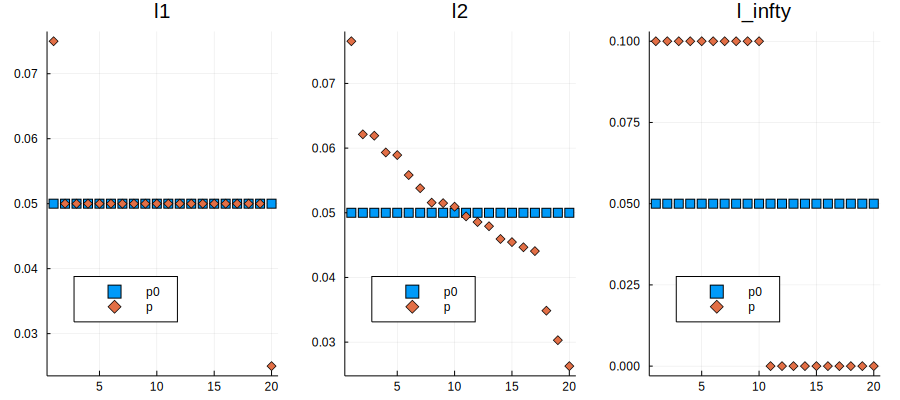

In [8]:
# scatter(1:n, p0,      label = "p0",    marker = :rect, legend = :topright)
# scatter!(1:n, p_l1,   label = "l1",    marker = :diamond)
# scatter!(1:n, p_l2,   label = "l2",    marker = :circle)
# scatter!(1:n, p_lInf, label = "l_Inf", marker = :star)

p1 = plot(legend = :bottomleft, title = "l1") 
scatter!(1:n, p0,   label = "p0", marker = :rect)
scatter!(1:n, p_l1, label = "p",  marker = :diamond)

p2 = plot(legend = :bottomleft, title = "l2")
scatter!(1:n, p0,   label = "p0", marker = :rect)
scatter!(1:n, p_l2, label = "p",  marker = :diamond)

p3 = plot(legend = :bottomleft, title = "l_infty")
scatter!(1:n, p0,     label = "p0", marker = :rect)
scatter!(1:n, p_lInf, label = "p",  marker = :diamond)

plot(p1, p2, p3, layout = (1,3), size = (900, 400))

### 1.2. Time comparison

In [9]:
function eval_l1(n)
    p0 = rand(Uniform(0,1), n);
    p0 /= sum(p0);
    c  = rand(Normal(0,1), n);
    ε  = 0.1;
    return Projections.minimize_linear_on_simplex_l1(p0, c, ε);
end;

function eval_l2(n, method::Symbol)
    p0 = rand(Uniform(0,1), n);
    p0 /= sum(p0);
    c  = rand(Normal(0,1), n);
    ε  = 0.1;
    return Projections.minimize_linear_on_simplex_l2(p0, c, ε, method = method);
end;

function eval_lInf(n)
    p0 = rand(Uniform(0,1), n);
    p0 /= sum(p0);
    c  = rand(Normal(0,1), n);
    ε  = 0.1;
    return Projections.minimize_linear_on_simplex_lInf(p0, c, ε);
end;

function eval_l2_philpott(n)
    p0 = rand(Uniform(0,1), n);
    p0 /= sum(p0);
    c  = rand(Normal(0,1), n);
    ε  = 0.1;
    return Projections.philpott(p0, c, ε);
end;

In [10]:
ls  = 2:0.2:5;
ns  = ceil.(Int64, 10 .^ls);

t_l1,           = timecomparison(eval_l1, ns; maxreps = 10);
t_l2_newton,    = timecomparison((n) -> eval_l2(n, :newton), ns; maxreps = 10);
t_l2_secant,    = timecomparison((n) -> eval_l2(n, :secant), ns; maxreps = 10);
t_l2_bisection, = timecomparison((n) -> eval_l2(n, :bisection), ns; maxreps = 10);
t_lInf,         = timecomparison(eval_lInf, ns; maxreps = 10);

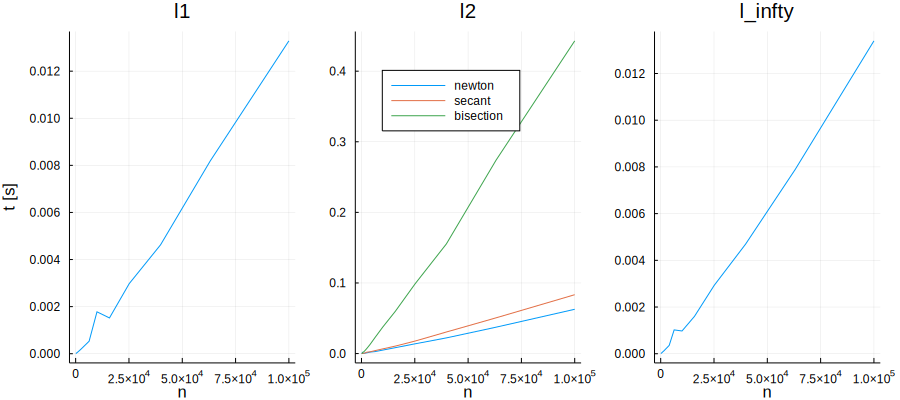

In [11]:
p1 = plot(legend = false, title = "l1", ylabel = "t [s]") 
plot!(ns,  t_l1)

p2 = plot(legend = :topleft, title = "l2")
plot!(ns, t_l2_newton,    label = "newton")
plot!(ns, t_l2_secant,    label = "secant")
plot!(ns, t_l2_bisection, label = "bisection")

p3 = plot(legend = false, title = "l_infty")
plot!(ns, t_lInf)

plot(p1, p2, p3, layout = (1,3), size = (900, 400))
xlabel!("n")

In [12]:
ls  = 2:0.1:3;
ns  = ceil.(Int64, 10 .^ls);

t_l2_philpott, = timecomparison(eval_l2_philpott, ns; maxreps = 10);
t_l2,          = timecomparison((n) -> eval_l2(n, :newton), ns; maxreps = 10);

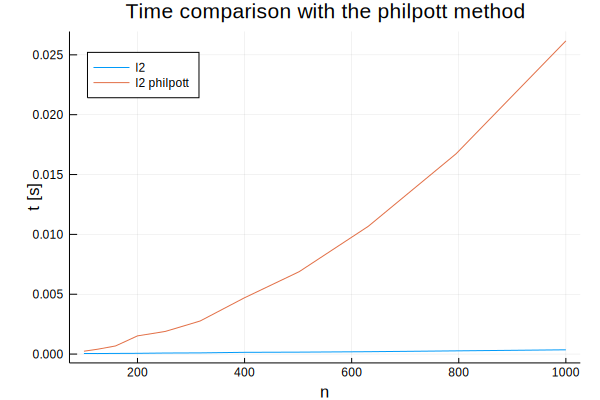

In [13]:
plot(legend = :topleft, title = "Time comparison with the philpott method")
plot!(ns, t_l2, label = "l2")
plot!(ns, t_l2_philpott, label = "l2 philpott")
xlabel!("n")
ylabel!("t [s]")

## 3. Problem (9) 

\begin{equation}\label{eq:problem4}
\begin{aligned}
\mnmz_{\bm p,\bm q, r}\ &\frac12\norm{\bm p - \bm p^0}^2 + \frac12\norm{\bm q - \bm q^0}^2 + \frac12(r-r^0)^2\\
\st\ &\sum_{i=1}^n p_i=\sum_{j=1}^m q_j,\\
&0\le p_i\le C_1,\quad\forall i=1,\dots,n,\\
&0\le q_j\le C_2r,\quad\forall j=1,\dots,m.
\end{aligned}
\end{equation}

### 2.1. Comparison with a solver

In [14]:
n  = 30;
m  = 30;
p0 = sort(rand(Normal(1/2,1), n));
q0 = sort(rand(Normal(1/2,1), m));
r0 = rand(Uniform(0,1))
C1 = 1;
C2 = 0.7;

In [15]:
p_solver, q_solver, r_solver = Projections.simplex_mod1_exact(p0, q0, r0, C1, C2);
p, q, r                      = Projections.simplex_mod1(p0, q0, r0, C1, C2; atol = atol);

In [16]:
L(p, p0, q, q0, r, r0) = norm(p - p0)/2 + norm(q - q0)/2 + norm(r - r0)/2

println("Comparison of our solution with the solution given by a solver \n")
println("‖p_solver - p‖ = ", norm(p_solver .- p));
println("‖q_solver - q‖ = ", norm(q_solver .- q));
println("‖r_solver - r‖ = ", norm(r_solver .- r), "\n");

println("Optimal solution: ")
println("  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 + ‖r-r0‖/2 = ", L(p_solver, p0, q_solver, q0, r_solver, r0))
println("  ⋅ ∑p = ∑q:       ", sum(p_solver), " = ", sum(q_solver))
println("  ⋅ min(p) ≧ 0:    ", minimum(p_solver), " ≧ ", 0)
println("  ⋅ min(q) ≧ 0:    ", minimum(q_solver), " ≧ ", 0)
println("  ⋅ max(p) ≦ C1:   ", maximum(p_solver), " ≦ ", C1)
println("  ⋅ max(q) ≦ C2*r: ", maximum(q_solver), " ≦ ", C2*r_solver, "\n")

println("Our solution: ")
println("  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 + ‖r-r0‖/2 = ", L(p, p0, q, q0, r, r0))
println("  ⋅ ∑p = ∑q:       ", sum(p), " = ", sum(q))
println("  ⋅ min(p) ≧ 0:    ", minimum(p), " ≧ ", 0)
println("  ⋅ min(q) ≧ 0:    ", minimum(q), " ≧ ", 0)
println("  ⋅ max(p) ≦ C1:   ", maximum(p), " ≦ ", C1)
println("  ⋅ max(q) ≦ C2*r: ", maximum(q), " ≦ ", C2*r)

Comparison of our solution with the solution given by a solver 

‖p_solver - p‖ = 5.628571537430726e-6
‖q_solver - q‖ = 2.8506097659728263e-6
‖r_solver - r‖ = 1.1633625440765627e-6

Optimal solution: 
  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 + ‖r-r0‖/2 = 3.8891540498962933
  ⋅ ∑p = ∑q:       17.188602130823394 = 17.188602130823323
  ⋅ min(p) ≧ 0:    1.422509146552108e-11 ≧ 0
  ⋅ min(q) ≧ 0:    5.696186324136144e-11 ≧ 0
  ⋅ max(p) ≦ C1:   0.999999999768112 ≦ 1
  ⋅ max(q) ≦ C2*r: 1.3760595227627552 ≦ 1.376059522864473

Our solution: 
  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 + ‖r-r0‖/2 = 3.889154291182843
  ⋅ ∑p = ∑q:       17.188596286572555 = 17.18859628657257
  ⋅ min(p) ≧ 0:    0.0 ≧ 0
  ⋅ min(q) ≧ 0:    0.0 ≧ 0
  ⋅ max(p) ≦ C1:   1.0 ≦ 1
  ⋅ max(q) ≦ C2*r: 1.3760603372182538 ≦ 1.3760603372182538


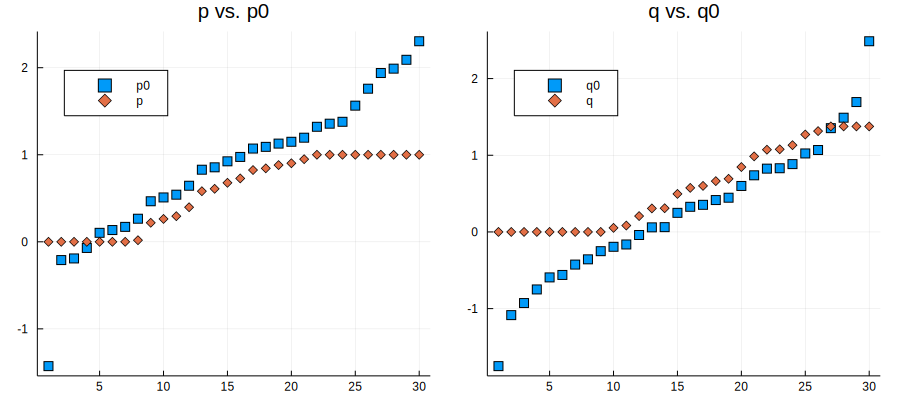

In [17]:
p1 = plot(legend = :topleft, title = "p vs. p0")
scatter!(1:n, p0,    label = "p0",       marker = :rect)
scatter!(1:n, p,     label = "p",        marker = :diamond)

p2 = plot(legend = :topleft, title = "q vs. q0")
scatter!(1:m, q0,    label = "q0",       marker = :rect)
scatter!(1:m, q,     label = "q",        marker = :diamond)

plot(p1, p2, layout = (1,2), size = (900, 400))

### 2.2. Time comparison

In [18]:
function eval_mod1(N, method::Symbol = :newton)
    n  = ceil(Int64, 0.3*N);
    m  = N - n;
    p0 = sort(rand(Normal(1/2,1), n));
    q0 = sort(rand(Normal(1/2,1), m));
    r0 = rand(Uniform(0,1))
    C1 = 2;
    C2 = 0.7;
    return Projections.simplex_mod1(p0, q0, r0, C1, C2; returnstats = true, method = method, atol = atol);
end;

In [19]:
ls  = 2:0.1:5
ns  = @. ceil(Int64, 10^ls);

ts, ts_std   = timecomparison((n) -> eval_mod1(n, :secant), ns; maxreps = 10);
tb, tb_std   = timecomparison((n) -> eval_mod1(n, :bisection), ns; maxreps = 10);

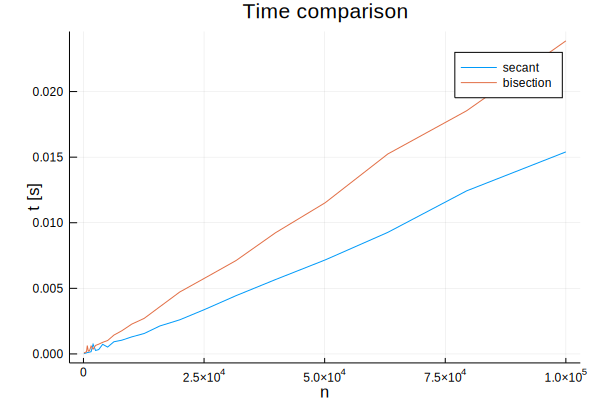

In [20]:
plot(ns,  ts, label = "secant")
plot!(ns, tb, label = "bisection")

title!("Time comparison")
xlabel!("n")
ylabel!("t [s]")

## 2. Problem (9) 

\begin{equation}\label{eq:problem3}
\begin{aligned}
\mnmz_{\bm p,\bm q}\ &\frac12\norm{\bm p - \bm p^0}^2 + \frac12\norm{\bm q - \bm q^0}^2\\
\st\ &\sum_{i=1}^n p_i=\sum_{j=1}^m q_j,\\
&0\le p_i\le C_1,\quad\forall i=1,\dots,n,\\
&0\le q_j\le \frac{1}{C_2}\sum_{i=1}^n p_i,\quad\forall j=1,\dots,m.
\end{aligned}
\end{equation}

### 2.1. Comparison with exact solution

In [21]:
# Jsem nakonec (8) a (9) v clanku zase prehodil. By to byl jinak hrozny chaos.

# Tento priklad neni dobry. Proto

n  = 30;
m  = 30;
p0 = sort(rand(Normal(0,1), n));
q0 = sort(rand(Normal(0,1), m));
C1 = 0.7;
C2 = 8;

In [22]:
p_solver, q_solver = Projections.simplex_mod2_exact(p0, q0, C1, C2);
p, q               = Projections.simplex_mod2(p0, q0, C1, C2; atol = atol);

In [23]:
L(p, p0, q, q0) = norm(p - p0)/2 + norm(q - q0)/2

println("Comparison of our solution with the solution given by a solver")
println("‖p_solver - p‖  = ", norm(p_solver .- p));
println("‖q_solver - q‖  = ", norm(q_solver .- q), "\n");

println("Our solution: ")
println("  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 = ", L(p, p0, q, q0))
println("  ⋅ ∑p = ∑q:          ", sum(p), " = ", sum(q))
println("  ⋅ min(p) ≧ 0:       ", minimum(p), " ≧ ", 0)
println("  ⋅ min(q) ≧ 0:       ", minimum(q), " ≧ ", 0)
println("  ⋅ max(p) ≦ C1:      ", maximum(p), " ≦ ", C1)
println("  ⋅ max(q) ≦ 1/C2*∑p: ", maximum(q), " ≦ ", sum(p)/C2)

println("Solver solution: ")
println("  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 = ", L(p_solver, p0, q_solver, q0))
println("  ⋅ ∑p = ∑q:          ", sum(p_solver), " = ", sum(q_solver))
println("  ⋅ min(p) ≧ 0:       ", minimum(p_solver), " ≧ ", 0)
println("  ⋅ min(q) ≧ 0:       ", minimum(q_solver), " ≧ ", 0)
println("  ⋅ max(p) ≦ C1:      ", maximum(p_solver), " ≦ ", C1)
println("  ⋅ max(q) ≦ 1/C2*∑p: ", maximum(q_solver), " ≦ ", sum(p_solver)/C2)

Comparison of our solution with the solution given by a solver
‖p_solver - p‖  = 4.646561069219888e-6
‖q_solver - q‖  = 2.681768481675046e-6

Our solution: 
  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 = 4.210364038359279
  ⋅ ∑p = ∑q:          9.92950921845769 = 9.92950921845769
  ⋅ min(p) ≧ 0:       0.0 ≧ 0
  ⋅ min(q) ≧ 0:       0.0 ≧ 0
  ⋅ max(p) ≦ C1:      0.7 ≦ 0.7
  ⋅ max(q) ≦ 1/C2*∑p: 1.2411886523072113 ≦ 1.2411886523072113
Solver solution: 
  ⋅ ‖p-p0‖/2 + ‖q-q0‖/2 = 4.2103639109006465
  ⋅ ∑p = ∑q:          9.929514292695208 = 9.929514292694838
  ⋅ min(p) ≧ 0:       -2.7301454806916547e-11 ≧ 0
  ⋅ min(q) ≧ 0:       5.464482219333126e-11 ≧ 0
  ⋅ max(p) ≦ C1:      0.6999999997403578 ≦ 0.7
  ⋅ max(q) ≦ 1/C2*∑p: 1.2411892859744686 ≦ 1.241189286586901


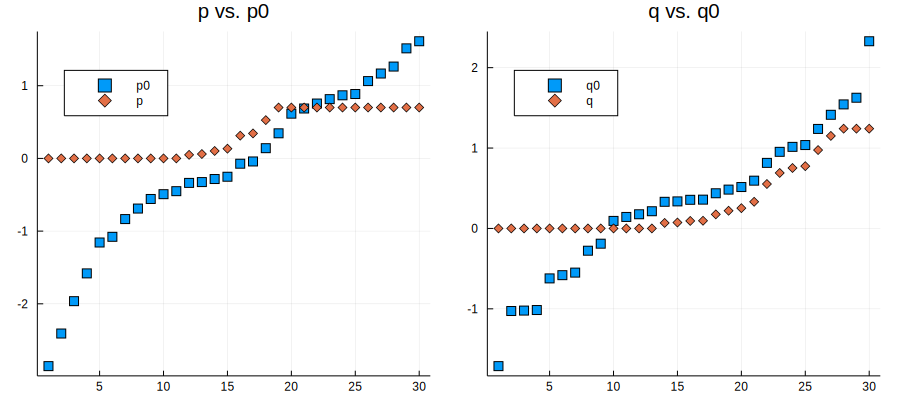

In [24]:
p1 = plot(legend = :topleft, title = "p vs. p0")
scatter!(1:n, p0,    label = "p0",       marker = :rect)
scatter!(1:n, p,     label = "p",        marker = :diamond)

p2 = plot(legend = :topleft, title = "q vs. q0")
scatter!(1:m, q0,    label = "q0",       marker = :rect)
scatter!(1:m, q,     label = "q",        marker = :diamond)

plot(p1, p2, layout = (1,2), size = (900, 400))

### 2.2. Time comparison

In [25]:
function eval_mod2(N, method::Symbol = :newton)
    n  = ceil(Int64, 0.3*N);
    m  = N - n;
    p0 = sort(rand(Normal(0,1), n));
    q0 = sort(rand(Normal(0,1), m));
    C1 = 2;
    C2 = ceil(Int64, m/10);
    return Projections.simplex_mod2(p0, q0, C1, C2; method = method, atol = atol);
end;

In [26]:
ls  = 2:0.1:5
ns  = @. ceil(Int64, 10^ls);

ts, ts_std   = timecomparison((n) -> eval_mod2(n, :secant), ns; maxreps = 10);
tb, tb_std   = timecomparison((n) -> eval_mod2(n, :bisection), ns; maxreps = 10);

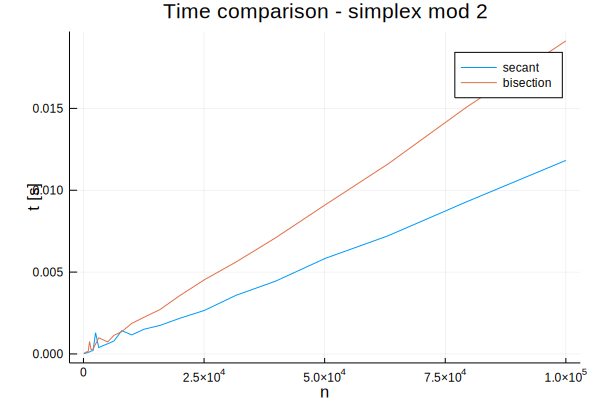

In [27]:
plot(ns, ts,  label = "secant")
plot!(ns, tb, label = "bisection")

title!("Time comparison - simplex mod 2")
xlabel!("n")
ylabel!("t [s]")